In [1]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import xml.etree.ElementTree as et
import os
import cv2
from matplotlib import pyplot as plt
import random
import numpy as np

In [2]:
def iou_cal(box1, box2):
    top_bound = max(box1[1], box2[1])
    bottom_bound = min(box1[3], box2[3])
    left_bound = max(box1[0], box2[0])
    right_bound = min(box1[2], box2[2])
    total_area = sum([(box[2] - box[0])*(box[3] - box[1]) for box in [box1, box2]])
    
    if left_bound >= right_bound or top_bound >= bottom_bound:
        return 0
    else:
        intersect = (right_bound - left_bound) * (bottom_bound - top_bound)
        return intersect / (total_area - intersect)

In [3]:
def file_parse(file_name):
    boxes = []
    current_path = os.path.abspath("./HW2_Data/Annotations/")
    xml_path = os.path.join(current_path, file_name+'.xml')
    tree = et.parse(xml_path)
    root = tree.getroot()
    for objects in root.findall('object'):
        for box in objects.findall('bndbox'):
            boxes.append([int(box.find('xmin').text), int(box.find('ymin').text), 
                         int(box.find('xmax').text), int(box.find('ymax').text)])
    
    current_path = os.path.abspath("./HW2_Data/JPEGImages/")
    jpg_path = os.path.join(current_path, file_name+'.jpg')
    img = cv2.imread(jpg_path)
    return boxes, img

In [4]:
def gt_compute(gt_list, proposal_list, img, thres):
    positive = 0
    for proposal in proposal_list:
        cv2.rectangle(img, (proposal[0], proposal[1]), (proposal[2], proposal[3]), [230,230,230], 1)
    for gt in gt_list:
        cv2.rectangle(img, (gt[0], gt[1]), (gt[2], gt[3]), [210,0,0], 2)
        for proposal in proposal_list:
            if iou_cal(gt, proposal)>=thres:
                cv2.rectangle(img, (proposal[0], proposal[1]), (proposal[2], proposal[3]), [0,235,50], 2)
                positive += 1
    return img, positive

In [5]:
def ss_seg(img, strategy, limit):
    if strategy == 'color':
        ss_strategy = cv2.ximgproc.segmentation.createSelectiveSearchSegmentationStrategyColor()
    elif strategy == 'texture':
        ss_strategy = cv2.ximgproc.segmentation.createSelectiveSearchSegmentationStrategyTexture()
    elif strategy == 'multiple':
        ss_strategy = cv2.ximgproc.segmentation.createSelectiveSearchSegmentationStrategyMultiple()
    else: return 0
    
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.addStrategy(ss_strategy)
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchQuality()
#     ss.switchToSelectiveSearchFast()
    boxes = ss.process()
    boxes[:,2], boxes[:,3] = boxes[:,0]+boxes[:,2], boxes[:,1]+boxes[:,3]
    return boxes[:limit]

In [6]:
def eb_seg(img, alpha, beta, limit):
    edge_detection = cv2.ximgproc.createStructuredEdgeDetection('model.yml')
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    edges = edge_detection.detectEdges(np.float32(rgb_img) / 255)
    orimap = edge_detection.computeOrientation(edges)
    edges = edge_detection.edgesNms(edges, orimap)
    
    edge_boxes = cv2.ximgproc.createEdgeBoxes()
    edge_boxes.setAlpha(alpha)
    edge_boxes.setBeta(beta)
    edge_boxes.setMaxBoxes(limit)
    boxes, scores = edge_boxes.getBoundingBoxes(edges, orimap)
    boxes[:,2], boxes[:,3] = boxes[:,0]+boxes[:,2], boxes[:,1]+boxes[:,3]
    return boxes, scores

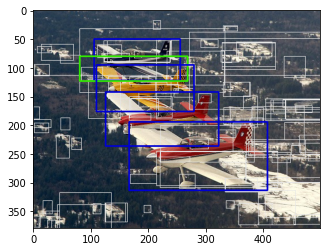

Selective search recall is 0.01


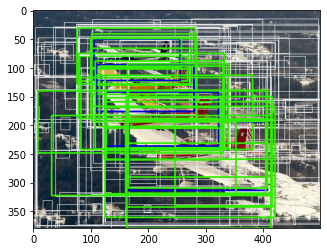

Edge boxes recall is 0.32


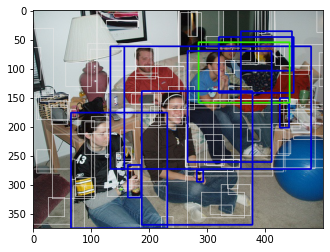

Selective search recall is 0.01


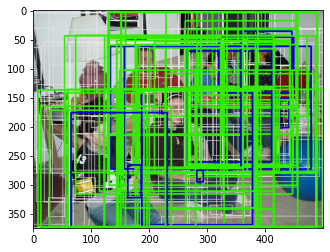

Edge boxes recall is 0.65


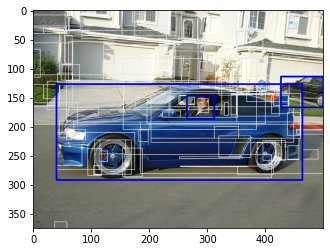

Selective search recall is 0.0


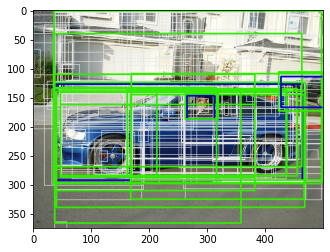

Edge boxes recall is 0.15


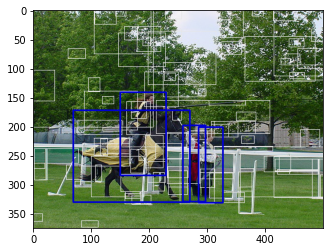

Selective search recall is 0.0


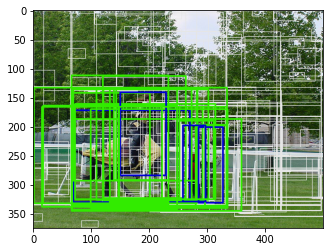

Edge boxes recall is 0.25


In [10]:
    file_list = {'000009', '000220', '002129', '006919'}
    strategy = 'multiple'
    limit = 100
    thres = 0.5
    alpha = 0.65
    beta = 0.75

if __name__ == '__main__':
    for file_name in file_list:
        gt_list, img = file_parse(file_name)
        img_copy = img.copy()
        
        ss_proposal = ss_seg(img_copy, strategy, limit)
        ss_img, ss_positive = gt_compute(gt_list, ss_proposal, img_copy, thres)
        ss_img = cv2.cvtColor(ss_img, cv2.COLOR_BGR2RGB)
        plt.imshow(ss_img)
        plt.show()
        print('Selective search recall is {}'.format(ss_positive/limit))
        
        eb_proposal, eb_scores = eb_seg(img_copy, alpha, beta, limit)
        eb_img, eb_positive = gt_compute(gt_list, eb_proposal, img_copy, thres)
        eb_img = cv2.cvtColor(eb_img, cv2.COLOR_BGR2RGB)
        plt.imshow(eb_img)
        plt.show()
        print('Edge boxes recall is {}'.format(eb_positive/limit))